# Random walk and diffusion-based methods

Although this book puts a heavy emphasis on spectral methods, there are many ways in which you can learn lower-dimensional representations for networks which don't involve spectral approaches. As opposed to spectral methods, a **random walk on a network** is a random process which focuses on the analysis of paths which start at a node in the network, and proceed to generate successions of random steps to other nodes in the network. The manner in which these random processes materialize is a function of the topology of the random network, including the nodes, edges, and (optionally, if the network is weighted), the edge weights. 

## A simplified first-order random walk on a network

For instance, let's consider an extremely simplified approach for a first-order random walk on the network that you saw back in [Chapter 4](#link?), which was our New York example. To begin, let's redefine the nodes and edges of the network. The nodes of the network are the five boroughs of New York City (Staten Island SI, Brooklyn BK, Queens Q, the Bronx BX, and Manhattan MH). The nodes in your network are the five boroughs. The edges $(i,j)$ of your network exist if one can travel from borough $i$ to borough $j$ along a bridge.

Below, you will look at a map of New York City, with the bridges connecting the different boroughs. In the middle, you look at this map as a network layout plot. The arrows indicate the direction of travel. On the right, you look at this map as an adjacency matrix:

In [106]:
import numpy as np

# define the node names
node_names = np.array(["SI", "MH", "BK", "Q", "BX"])
# define the adjacency matrix
A = np.array([[0,0,1,0,0],  # staten island is neighbors of brooklyn
              [0,0,1,1,1],  # manhattan is neighbors of all but staten island
              [1,1,0,0,0],  # brooklyn is neighbors of staten island and manhattan
              [0,1,0,0,1],  # queens is neighbors of manhattan and bronx
              [0,1,0,1,0]]) # bronx is neighbors of manhattan and queens

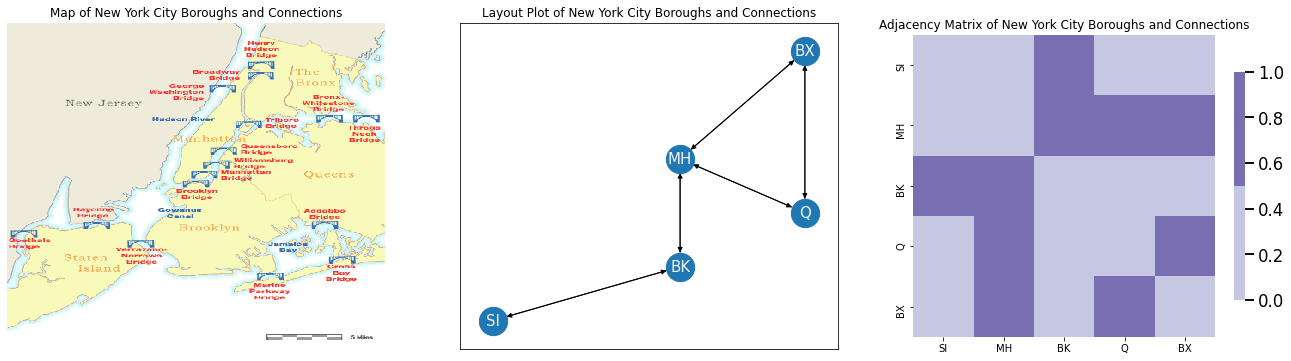

In [107]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from graphbook_code import heatmap

img = mpimg.imread('../ch4/img/newyork.png')

G = nx.DiGraph()

G.add_node("SI", pos=(1,1))
G.add_node("MH", pos=(4,4))
G.add_node("BK", pos=(4,2))
G.add_node("Q", pos=(6,3))
G.add_node("BX", pos=(6,6))

pos = nx.get_node_attributes(G, 'pos')
G.add_edge("SI", "BK")
G.add_edge("MH", "BK")
G.add_edge("MH", "Q")
G.add_edge("MH", "BX")
G.add_edge("Q", "BX")

G.add_edge("BK", "SI")
G.add_edge("BK", "MH")
G.add_edge("Q", "MH")
G.add_edge("BX", "MH")
G.add_edge("BX", "Q")

fig, axs = plt.subplots(1,3, figsize=(23, 6))
axs[0].imshow(img, alpha=.8, interpolation='nearest', aspect='auto')
axs[0].axis('off')
axs[0].set_title("Map of New York City Boroughs and Connections")
nx.draw_networkx(G, pos, ax=axs[1], with_labels=True, node_color="tab:blue", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
axs[1].set_title("Layout Plot of New York City Boroughs and Connections")
heatmap(A, ax=axs[2], xticklabels=[0.5,1.5,2.5,3.5,4.5], yticklabels=[0.5,1.5,2.5,3.5,4.5])
axs[2].set_title("Adjacency Matrix of New York City Boroughs and Connections")
axs[2].set_xticklabels(node_names)
axs[2].set_yticklabels(node_names)
fig;

You are staying at a hotel which is located in Manhattan, and you decide that you are going to explore the city as follows. When you are in a given borough $i$, you will determine the next borough you will explore by letting random chance do the work for you. To better define a first-order random walk, we need to introduce a background concept first: the Markov chain and the Markov property. 

### Markov chains and the markov property

A **finite-space markov chain** is a model of a random system in which we have a sequence of possible events which can occur which are *finite* (the boroughs we will visit on a day $t$) in which the probability of each event depends *only* on the event in which you were previously. For network analysis, we only need to think about *finite-space* Markov chains, because the network has a *finite* collection of possible events which can occur (the nodes in the network being visited). To put this down quantitatively, the markov chain is represented by the sequence $\mathbf s_0, \mathbf s_1, \mathbf s_2, ...$, where each $\mathbf s_t$ takes the value of one of the $n$ total nodes in the network. 

You will notice that in our definition of the finite-space markov chain, we made a disclaimer: the probability of each event depends *only* on the state in which we were previously. This is called the **markov property**. The idea is that, if we were in Manhattan at the previous step in time $t - 1$ (e.g., $\mathbf s_{t-1}$ realized the value $v_{MH}$, or $\mathbf s_{t-1} = v_{MH}$ for short), that if our current step in the Markov Chain were Brooklyn ($\mathbf s_t = v_{BK}$), that the next step in the Markov chain would not depend *at all* on the fact that we already saw Manhattan. 

#### First-order random walks on a network as a markov chain

To exhibit the ideas of a markov chain, we'll define a first-order random walk on your New York Boroughs. Remember that the borough you are at, $i$, has $d_i$ possible neighboring boroughs, where $d_i$ was the *degree* of node $i$. You will visit one of the other nodes in the network as follows. If borough $j$ is a neighbor of borough $i$ (an edge exists from borough $i$ to borough $j$), you will visit borough $j$ with probability $\frac{1}{d_i}$. The idea is that you will visit neighbors of each borough at random, depending only on whether you can get to that borough along an edge of the network. This is called a **first-order random walk** because it is a random walk where you *ignore* everything about the path you have taken to get to your current *borough* to date, except for the fact that you are at that borough *now*. This means that your next borough will not depend *at all* on whether you have already been to that borough in your exploration of the city. If the node is not a neighbor of your current borough, you will visit it with probability $0$. Stated another way, if you are in node $i$, the probability of going to another node $j$ is defined as:
\begin{align*}
    p_{ij} &= \begin{cases}
        \frac{1}{d_i}  & \text{edge $(i,j)$ exists} \\
        0  & \text{edge $(i,j)$ does not exist}
    \end{cases}
\end{align*}
Note that these probabilities, called the **transition probability** from node $i$ to node $j$, do not have *anything* to do with which nodes we have visited yet, and these transition probabilities are *always the same*! For this reason, they are often organized into a matrix, called the **transition probability matrix** $P$. In this case, the transition probability matrix looks like this:

In [108]:
# compute the degree of each node
di = A.sum(axis=0)
# the probability matrix is the adjacency divided by
# degree of the starting node
P = (A / di).T

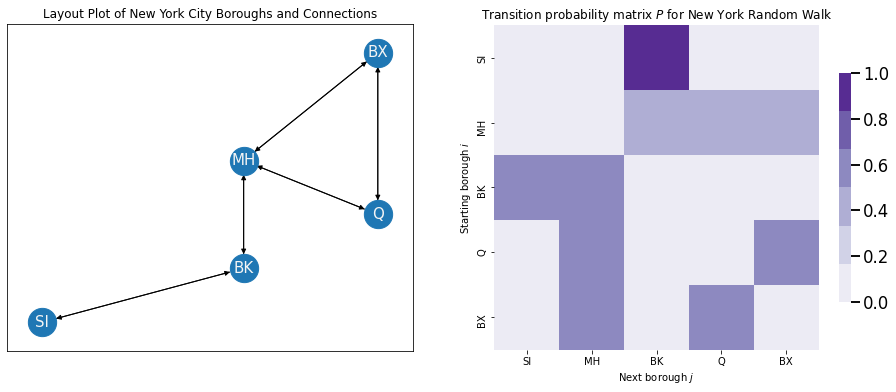

In [109]:
fig, axs = plt.subplots(1,2, figsize=(16, 6))

nx.draw_networkx(G, pos, ax=axs[0], with_labels=True, node_color="tab:blue", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
axs[0].set_title("Layout Plot of New York City Boroughs and Connections")
heatmap(P, ax=axs[1], xticklabels=[0.5,1.5,2.5,3.5,4.5], yticklabels=[0.5,1.5,2.5,3.5,4.5])
axs[1].set_title("Transition probability matrix $P$ for New York Random Walk")
axs[1].set_xticklabels(["SI", "MH", "BK", "Q", "BX"])
axs[1].set_yticklabels(["SI", "MH", "BK", "Q", "BX"])
axs[1].set_ylabel("Starting borough $i$")
axs[1].set_xlabel("Next borough $j$")
fig;

To understand this transition probability matrix, let's think about the individual rows. Notice that if you are in Staten Island, there is only one borough you can go from here, so with probability $1$, you will visit its only neighbor: Brooklyn. If you are in Manhattan, you could go to any of its three neighbors (Brooklyn, Queens, or Bronx), with equal probability $\frac{1}{3}$. If you were in Brooklyn, you could visit any of its two neighbors (Manhattan or Staten Island) with equal probability $\frac{1}{2}$. This continues for each node in the network until you have successfully generated the transition probability matrix $P$.

There are a lot of interesting properties you can use the transition probability matrix $P$ to learn about, but we won't cover them all here. If you want some more details on transition probability matrices and Markov chains in general, we would recommend that you check out a book on stochastic processes, such as the author's favorite by Dean Isaacson, called [Markov Chains: Theory and Applications](https://www.amazon.com/dp/0471428620?tag=uuid10-20).

Next, let's use this transition probability matrix to generate a random walk on the New York City boroughs. As we mentioned, your hotel is in Manhattan, so you are going to start your random walk through the city here. In other words, $\mathbf s_0 = v_{MH}$. For your next step in the Markov chain, you will visit either Brooklyn, Bronx, or Queens with probability $\frac{1}{3}$, or Staten Island with probability $0$. In the following figure, we show the place you start out at, Manhattan, in blue, and the other nodes in gray:

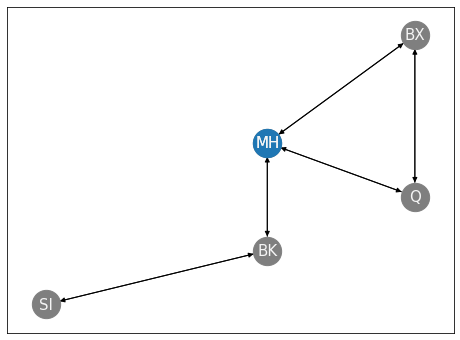

In [110]:

G = nx.DiGraph()

G.add_node("SI", pos=(1,1))
G.add_node("MH", pos=(4,4))
G.add_node("BK", pos=(4,2))
G.add_node("Q", pos=(6,3))
G.add_node("BX", pos=(6,6))

pos = nx.get_node_attributes(G, 'pos')
G.add_edge("SI", "BK")
G.add_edge("MH", "BK")
G.add_edge("MH", "Q")
G.add_edge("MH", "BX")
G.add_edge("Q", "BX")

G.add_edge("BK", "SI")
G.add_edge("BK", "MH")
G.add_edge("Q", "MH")
G.add_edge("BX", "MH")
G.add_edge("BX", "Q")

Ghl = nx.DiGraph()
Ghl.add_node("MH")

fig, ax = plt.subplots(1,1, figsize=(8, 6))
nx.draw_networkx(G, pos, ax=ax, with_labels=True, node_color="tab:gray", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
nx.draw_networkx(Ghl, pos, ax=ax, with_labels=True, node_color="tab:blue", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)

You can visit each of the neighboring nodes, shown in the next plot teal yellow, and the probabilities of visiting each of these nodes are correspondingly highlighted in the transition probability matrix with a blue block:

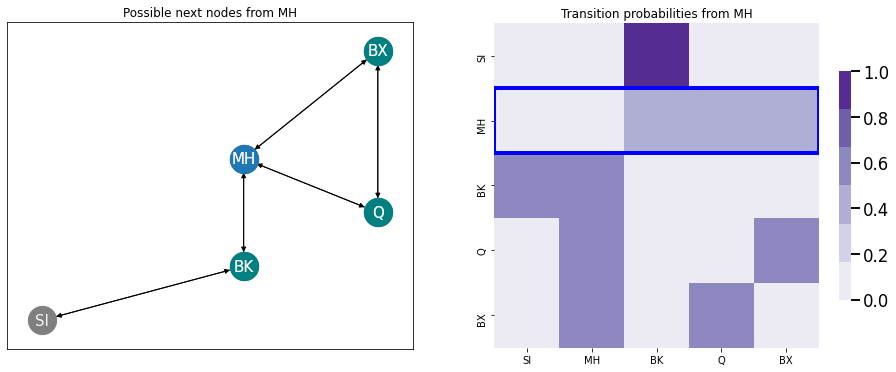

In [111]:
import matplotlib.patches as patches
Gn = nx.DiGraph()
Gn.add_node("BX")
Gn.add_node("BK")
Gn.add_node("Q")
fig, ax = plt.subplots(1,2, figsize=(16, 6))
nx.draw_networkx(G, pos, ax=ax[0], with_labels=True, node_color="tab:gray", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
nx.draw_networkx(Ghl, pos, ax=ax[0], with_labels=True, node_color="tab:blue", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
nx.draw_networkx(Gn, pos, ax=ax[0], with_labels=True, node_color="teal", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
ax[0].set_title("Possible next nodes from MH")

heatmap(P, ax=ax[1], xticklabels=[0.5,1.5,2.5,3.5,4.5], yticklabels=[0.5,1.5,2.5,3.5,4.5])
ax[1].set_title("Transition probabilities from MH")
ax[1].set_xticklabels(["SI", "MH", "BK", "Q", "BX"])
ax[1].set_yticklabels(["SI", "MH", "BK", "Q", "BX"])

ax[1].add_patch(
     patches.Rectangle(
         (0,1),
         5.0,
         1.0,
         edgecolor='blue',
         fill=False,
         lw=4
     ) )

fig;

You then choose the next node to visit, using these transition probabilities, by generating the probability vector of the *next step* in the random walk *given the current step*. We will denote this probability vector with the symbol $\vec p^{(t+1)}_i$, which is the probability vector for which node you will visit at the next step $t+1$ given that you are currently at node $i$. Notice that this is just the entries of the $i^{th}$ row of the transition probability matrix, which can be calculated using the relationship:
\begin{align*}
    \vec p^{(t+1)}_i &= P^\top \vec x^{(i)}
\end{align*}
where $\vec x^{(i)}$ is the vector which has a value of $0$ for all entries except for entry $i$, where it has a value of $1$. This ends up *pulling out* the $i^{th}$ row of $P$, because every multiplication except for those against the $i^{th}$ column of $P^\top$ (which is the $i^{th}$ row of $P$, by definition of a transpose) will end up just being $0$! We can see this with the following detailed exploration:
\begin{align*}
    \vec p^{(t+1)}_i &= \begin{bmatrix}
    p_{11} & ... & p_{1n} \\
    \vdots & \ddots & \vdots \\
    p_{n1} & ... & p_{nn}
    \end{bmatrix}^\top\vec x^{(i)} \\
     &= \begin{bmatrix}
    p_{11} & ... & p_{n1} \\
    \vdots & \ddots & \vdots \\
    p_{1n} & ... & p_{nn}
    \end{bmatrix}^\top\vec x^{(i)},\;\;\;\;\text{in this step, we just transposed $P$} \\
    &= \begin{bmatrix}
        p_{11}x_{1}^{(i)} + p_{21} x_2^{(i)} + ... p_{n1}x_n^{(i)} \\
        \vdots \\
        p_{1n}x_{1}^{(i)} + p_{2n} x_2^{(i)} + ... p_{nn}x_n^{(i)} 
    \end{bmatrix},\;\;\;\;\text{the definition of matrix multiplication} \\
    &= \begin{bmatrix}
        p_{i1} \\
        \vdots \\
        p_{in}
    \end{bmatrix}
\end{align*}
where the last step in the multiplication is because $x_{i}^{(i)}$ is the only entry which has a value of $1$, so all of the other multipilications are just $0$. We can pick the next node easily by just using `numpy`:

In [112]:
xt = np.array([0,1,0,0,0])  # x vector indicating we start at MH
pt2 = P.T @ xt  # p vector for timestep t+1 starting at node MH at time t
# choose the next node using the probability vector we calculated
next_node = np.random.choice(range(0, len(node_names)), p=pt2)
print("Next node: {:s}".format(node_names[next_node]))

Next node: BX


We indicate the path we took between Manhattan and our realized next node in green, shown below:

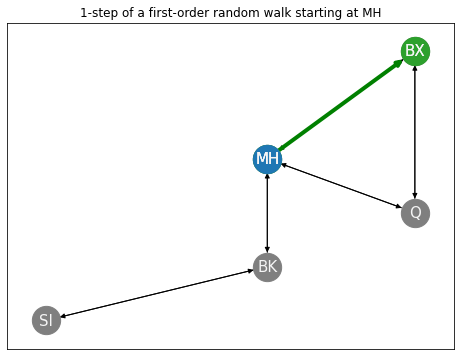

In [113]:
next_name = node_names[next_node]
Gnext = nx.DiGraph()
Gnext.add_node("MH")
Gnext.add_node(next_name)
Gnext.add_edge("MH", next_name)
fig, ax = plt.subplots(1,1, figsize=(8, 6))
nx.draw_networkx(G, pos, ax=ax, with_labels=True, node_color="tab:gray", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
nx.draw_networkx(Gnext, pos, ax=ax, with_labels=True, node_color="tab:green", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True, edge_color="green", width=4)
nx.draw_networkx(Ghl, pos, ax=ax, with_labels=True, node_color="tab:blue", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
ax.set_title("1-step of a first-order random walk starting at MH");

This gives us a realization of $\mathbf s_1$ as the indicated node in the network, conditional on the starting node being $\mathbf s_0 = v_{MH}$. We repeat this process again to give us a realization of $\mathbf s_2$, conditional on $\mathbf s_1$'s value which we just calculated a realization of.

We then repeat this procedure over and over again on the network to obtain a realization of a random walk on the New York boroughs, given only the starting node $\mathbf s_0 = v_{MH}$.

## What do markov chains and random walks have to do with embedding networks?

In the preface for this section, we said we were going to cover how to use a random walk to embed our network, but we've ignored that thus far! To get us to what this has to do with embeddings, we need to introduce a slight variation of the random walk we developed in the preceding section, called the second-order biased random walk.

### Second-order biased random walk

Remember when we developed our first-order random walk, we did something kind of nonsensical: we ignored all of the previous boroughs of New York you had already seen, and said that the next borough was *only* a function of the current borough you are at. You could certainly imagine that you get caught in a legitimate random walk (it is a *possible realization* because all of the transition probabilities are *positive*) where you explore going from Manhattan to Brooklyn, and then over to Staten Island, and then back to Brooklyn, and then back to Staten Island, so on and so forth, because you *totally ignored* the previous places you had been when making your decision for where to go from your current borough. 

If you are a tourist trying to explore New York, you obviously will want to get a better sense of *all* of the city, and want to favor the boroughs you haven't been to as recently! In the second-order biased random walk, we introduce the idea of the return and in-out parameters, $p$ and $q$, respectively. 

#### The bias factor lets us control our ability to *leave* or *remain* amongst a neighborhood of nodes

Remember that the steps in our random walk, $\left\{\mathbf s_0, \mathbf s_1, ..., \mathbf s_{t-1}, \mathbf s_t, ...\right\}$, were sequences of random variables which took values of our nodes in the network. Let's assume that we have a random walk so far, where at our previous state, $\mathbf s_{t-1} = s_{t-1}$, and we are currently at node $i$, $\mathbf s_t = i$. Here, $s_{t-1}$ is some other node which we just came from to get to node $i$.

The **in-out** parameter $q$ is a value which indicates a bias factor of $\frac{1}{q}$ that we will go to some node $j$ that is *totally* disconnected from the previous node that we visited, $s_{t-1}$. This means that in our network, there is no edge starting at node $j$ and going to node $s_{t-1}$. If the in-out parameter $q$ takes big values, then $\frac{1}{q}$ will be very small, and we will be biased *against* visiting nodes which are not connected to the previous node we visited. If $q$ is small, then $\frac{1}{q}$ will be very big, and we will be biased *towards* visiting nodes which are not connected to the previous node we visited.

The **return** parameter $p$ is a value which indicates a bias factor of $\frac{1}{p}$ that we will *go back* to the node which we visited previously in the last state $s_{t-1}$. If the return parameter $p$ takes big values, $\frac{1}{p}$ will be very small, and we will be biased *against* visiting a node we have just been to. If $p$ is small, then $\frac{1}{p}$ will be very big, and we will be biased *towards* visiting a node which we were just at.

If a node satisfies neither of these conditions, the bias factor is just left at $1$. Together, these relationships are summarized with the **bias factor** $\alpha_{ij}^{(t+1)}(p,q, s_{t-1})$ starting at node $i$ and proceeding to node $j$ with parameters $p$ and $q$ for the next step $t+1$ given that we just left state $s_{t-1}$ as:
\begin{align*}
    \alpha_{ij}(p,q,s_{t-1}) &= \begin{cases}
        \frac{1}{p} & \text{$s_{t-1} = j$} \\
        \frac{1}{q} & \text{$s_{t-1} \neq j$ and the edge $(j,s_{t-1})$ exists} \\
        1 & \text{$s_{t-1} \neq j$ and no edge $(j,s_{t-1})$ exists}
    \end{cases}
\end{align*}
And the corresponding bias vector $\vec \alpha_i(p,q, s_{t-1})$, which is a vector of each of the bias factors for all of the $n$ nodes in the network (which are indexed by $j$).

Let's use our New York example to get a sense of how these bias vectors work. We'll consider a random walk at some arbitrary current state $t$, where the current node we are on is Manhattan ($s_t = v_{MH}$) and is shown in blue, and the previous node we visited was Queens ($s_{t-1} = v_{Q}$) and is shown in orange. We just visited node $Q$, so the bias factor will be $\frac{1}{p}$ (the edge is shown in orange). The node for Bronx has an edge back to Queens, so the bias factor will be $\frac{1}{q}$ (the edge is shown in purple). The node for Brooklyn does not have an edge back to queens, so the bias is $1$ (and the edge is shown in black):

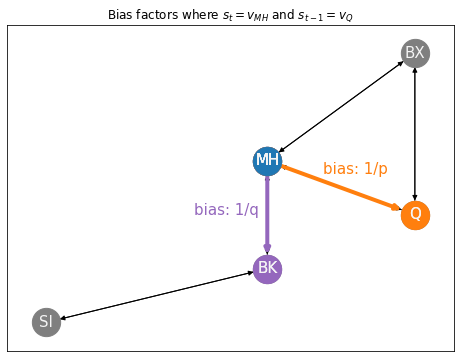

In [114]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))
nx.draw_networkx(G, pos, ax=ax, with_labels=True, node_color="tab:gray", node_size = 800,
                 font_size=15, font_color="whitesmoke", arrows=True)
ax.set_title("Bias factors where $s_t = v_{MH}$ and $s_{t-1} = v_{Q}$")

nx.draw_networkx(Ghl, pos, ax=ax, with_labels=True, node_color="tab:blue", node_size = 800,
                 font_size=15, font_color="whitesmoke", arrows=True)
Gin = nx.DiGraph()
Gin.add_node("BK", pos=(1,1))
Gin.add_node("MH", pos=(4,4))
Gin.add_edge("MH", "BK")

nx.draw_networkx(Gin, pos, ax=ax, with_labels=True, node_color="tab:purple", node_size = 800,
                 font_size=15, font_color="whitesmoke", arrows=True, edge_color="tab:purple",
                 width=4)
Gret = nx.DiGraph()
Gret.add_node("Q")
Gret.add_node("MH")
Gret.add_edge("MH", "Q")

nx.draw_networkx(Gret, pos, ax=ax, with_labels=True, node_color="tab:orange", node_size = 800,
                 font_size=15, font_color="whitesmoke", arrows=True, edge_color="tab:orange",
                 width=4)
nx.draw_networkx(Ghl, pos, ax=ax, with_labels=True, node_color="tab:blue", node_size = 800,
                 font_size=15, font_color="whitesmoke", arrows=True)
ax.annotate("bias: 1/p", (4.75, 3.75), size=15, color="tab:orange")
ax.annotate("bias: 1/q", (3, 3), size=15, color="tab:purple");

If we were to tend to bias against returning (a large return parameter, say $p = 5$) and towards in-out (a small in-out parameter, say $q = \frac{1}{2}$), the bias vector will look like this:

In [148]:
p = 5  # return parameter
q = 1/2  # in-out parameter
bias_vector = np.ones(len(node_names))
bias_vector[node_names == "Q"] = 1/p
bias_vector[node_names == "BK"] = 1/q

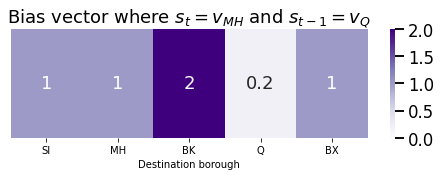

In [307]:
import seaborn as sns

def plot_vec(vec, title="", blockname="Destination borough", 
             blocklabs=node_names,
             blocktix=[0.5 + i for i in range(0, len(node_names))],
             vmax=None, ax=None, cbar=True, cbar_ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 2))
    
    if vmax is None:
        vmax = vec.max()
    with sns.plotting_context("talk", font_scale=1):
        if cbar_ax is not None:
            ax = sns.heatmap(vec.reshape((1,vec.shape[0])), cbar=cbar, cbar_ax=cbar_ax, cmap="Purples",
                            ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                            xticklabels=False, vmin=0, vmax=vmax, annot=True)
        else:
            ax = sns.heatmap(vec.reshape((1,vec.shape[0])), cbar=cbar, cmap="Purples",
                            ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                            xticklabels=False, vmin=0, vmax=vmax, annot=True)
        ax.set_title(title)
        ax.set(xlabel=blockname)
        ax.set_xticks(blocktix)
        ax.set_xticklabels(blocklabs)
        if cbar_ax is None and cbar:
            cbar = ax.collections[0].colorbar
            cbar.ax.set_frame_on(True)
    return

plot_vec(bias_vector, title="Bias vector where $s_t = v_{MH}$ and $s_{t-1} = v_{Q}$")

#### Adjusting the transition probabilities with the bias vector

In our second order random walk, instead of the transition probabilities being a function only of the *current* state, they are also a function of the preceding state we were at $s_{t-1}$. This means that our transition probability matrix is going to look *different* based on which node we just came from. The transition probabilities are defined using the indexed *triplet* $p_{s_{t-1}ij}(p,q)$, where $s_{t-1}$ is the preceding node we visited, $i$ is the current node we are at, $j$ is any other node in the network, and $p$ and $q$ are the return and in-out parameters respectively. The **second-order biased transition factors** the terms:
\begin{align*}
    \beta_{s_{t-1}ij}(p,q) &= \alpha_{ij}(p, q, s_{t-1})p_{ij}
\end{align*}
where $p_{ij}$ are the first-order markov transition probabilities we used previously. These are called *second-order* because they depend on the current node, $i$, as well as the preceding node, $s_{t-1}$.

In effect, what this statement says is that all we do is *up* or *down*-weight (or don't change it at all, if the bias factor is $1$) the probability $p_{ij}$ of going from node $i$ to node $j$ based on the *bias factor* $\alpha_{ij}(p, q, s_{t-1})$. These are no longer probabilities, because starting at a node $i$, we might end up with the bias-adjusted transition factors no longer summing to one. This is because we did not require anything about how $\alpha_{ij}^{(t+1)}(p,q,s_{t-1})$ behaved across all possible nodes $j$ we could transition to from our current node $i$.

Finally, we then use the biased transition factors to compute the **second-order biased transition probabilities**. These are just normalized versions of the biased transition factors, where we normalize to make sure that they all sum up to one (and hence, produce a valid transition probability from node $i$ outwards):
\begin{align*}
    p_{s_{t-1}ij}(p,q) &= \frac{\beta_{s_{t-1}ij}(p,q)}{\sum_{j' = 1}^n\beta_{s_{t-1}ij'}(p,q)}
\end{align*}
Notice that in the denominator, that we are just normalizing the bias-adjusted transition factor by the sum of all the other bias-adjusted transition factors from node $i$ to any other nodes $j'$ in the network. 

Next, we show how this computation works to update the transition probability vector from the Manhattan node to node $j$ given a previous node of Queens. We begin by first starting with the first-order transition probability vector $\vec p_i$:

In [308]:
xstart = [0, 1, 0, 0, 0]  # starting vector at MH
pvec = P.T @ xstart  # probability vector is Pt*x

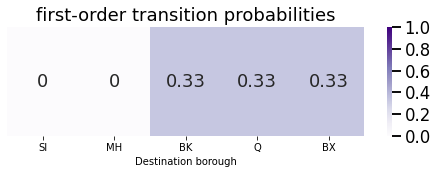

In [309]:
plot_vec(pvec, title="first-order transition probabilities", vmax=1)

Next, we compute the bias vector, exactly as we did previously:

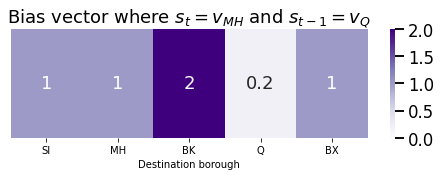

In [310]:
plot_vec(bias_vector, title="Bias vector where $s_t = v_{MH}$ and $s_{t-1} = v_{Q}$")

The next step is to compute the second-order biased transition factors:

In [311]:
bias_factors = pvec*bias_vector

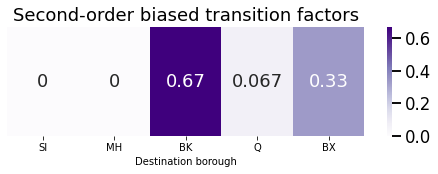

In [312]:
plot_vec(bias_factors, title="Second-order biased transition factors")

And finally, to normalize the bias-adjusted transition factors to obtain the second-order biased transition probabilities. We compare the second-order biased transition probabilities to the first-order transition probabilities, so that you can see the impact that the second-order biasing procedure had on our probability vector:

In [313]:
biased_pvec = bias_factors/bias_factors.sum()

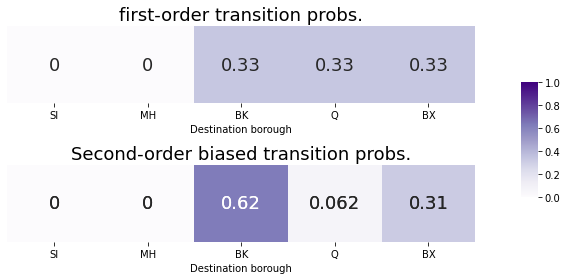

In [316]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(2, 1, figsize=(8, 4))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

prob_vecs = [pvec, biased_pvec, biased_pvec]
titles = ["first-order transition probs.", "Second-order biased transition probs."]
for i, ax in enumerate(axs.flat):
    plot_vec(prob_vecs[i], ax=ax, vmax=1, cbar=i==2, 
             cbar_ax= cbar_ax if i == 2 else None, title=titles[i])
i=2
plot_vec(biased_pvec, ax=axs[1], vmax=1, cbar=i==2, 
             cbar_ax= cbar_ax, title="Second-order biased transition probs.")
    
fig.tight_layout(rect=[0, 0, .85, 1])

As we can see, our tendency to *return* to Queens (since we were just there in the previous step, $s_{t-1} = v_{Q}$) has decreased from the first-order transition probability to the second-order biased transition probability, due to the fact that the return parameter is big ($p = 5$). Further, our tendency to move in-out to Brooklyn (since Brooklyn has no edges to Queens) has increased from the first-order transition probability to the second-order biased transition probability, due to the fact that the in-out parameter is small ($q = 0.2$). The transition probability for the remaining nodes, such as BX, with a bias of $1$ are less affected from the first-order to the second-order biased transition probability.

## node2vec

node2vec is one such method. Instead of relying on taking eigenvectors or eigenvalues, like a Laplacian, node2vec uses a random walk to preserve the relationships between nodes and their *local neighborhoods*: all of the nodes which you can get to by walking along a small number of edges from your starting node. For example, take 

<AxesSubplot:>

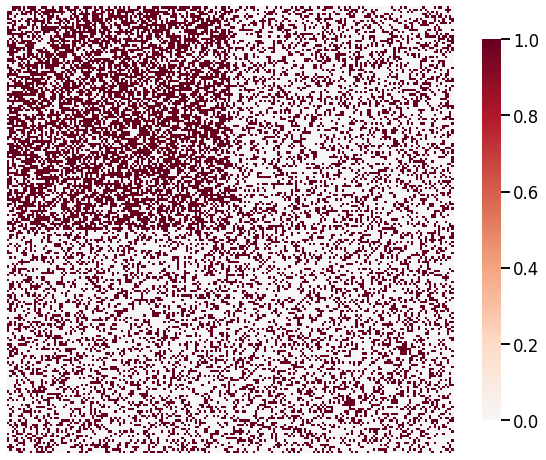

In [26]:
from graspologic.embed import node2vec_embed
from graspologic.simulations import sbm
from graspologic.plot import heatmap
import numpy as np
import networkx as nx

# Start with some simple parameters
N = 300  # Total number of nodes
n = N // 3  # Nodes per community
B = np.array([[.6, .3],
              [.3, .3]])  # Our block probability matrix

# Make our Stochastic Block Model
A, labels = sbm([n, n], B, return_labels = True)

heatmap(A)

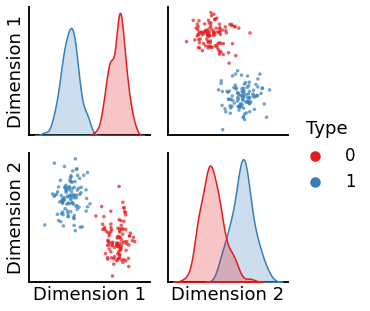

In [27]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

ase = ASE(n_components=2)
latents = ase.fit_transform(A)

pairplot(latents, labels=labels)

In [24]:
from graspologic.plot import pairplot

networkx_sbm = nx.Graph(A)
a, nodes = node2vec_embed(networkx_sbm, dimensions=2, walk_length=100)
pairplot(a, labels=labels)

NameError: name 'node2vec_embed' is not defined

## Extending to weighted networks